In [1]:
import numpy as np
import torch
import scanpy as sc
import pandas as pd
import os
import yaml
from pathlib import Path

from sklearn.metrics import adjusted_rand_score as ari_score

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.decomposition import PCA


In [2]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='imputation', key_added_pred='impute_mclust',
             random_seed=666):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """

    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(adata.obsm[used_obsm], num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added_pred] = mclust_res
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata

In [3]:
from utils.Func import *
from utils.Utils import *
from MGAC import Mgac

In [4]:
with open('Config/MBA_CLFS.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [5]:
data_path = "E:/Topic/st cluster/data/MBA"  #### to your path

num_clusters = 52

config['data']['dataset_slice'] = 'mba'
data_root = Path(data_path)
adata = sc.read_visium(f'{data_root}/Mouse_Brain_Anterior_Section1', count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

d:\app\python\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\app\python\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
##### Load layer_guess label, if have
turth_path = f'{data_root}/metadata.tsv'
truth_labels = pd.read_csv(turth_path, sep='\t', header=0)
truth_labels.index = adata.obs_names
adata.obs['layer_guess'] = truth_labels['ground_truth']

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

image_path = f"{data_path}/Mouse_Brain_Anterior_Section1/preprocess/image/uni_image_feat.npy"
image_feat = np.load(image_path)
# image_feat = image_feat[~pd.isnull(adata.obs['layer_guess']).values]
image_feat_pca = PCA(n_components=200, random_state=42).fit_transform(image_feat)
adata.obsm['img_pca'] = torch.tensor(image_feat_pca)

graph_dict = graph_construction(adata, config['data']['k_cutoff'])

d:\app\python\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
E:\Topic\st cluster\code\CLDCA\utils\Func.py:59: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [7]:
# %%
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = Mgac(adata, graph_dict=graph_dict, num_clusters=num_clusters, device=device, config=config)
net.train()

Epoch 99 total loss=0.343 recon loss=0.702 match loss=0.618: 100%|██████████| 100/100 [00:04<00:00, 20.77it/s]


[]

In [8]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon

In [9]:
type(adata)

anndata._core.anndata.AnnData

In [10]:
adata = mclust_R(adata, num_cluster=num_clusters, used_obsm='latent', key_added_pred='mclust')
adata.obs['domain'] = refine_label(adata, 30, key='mclust')
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['domain'])
print("ARI:", ARI)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
ARI: 0.5223089799343228


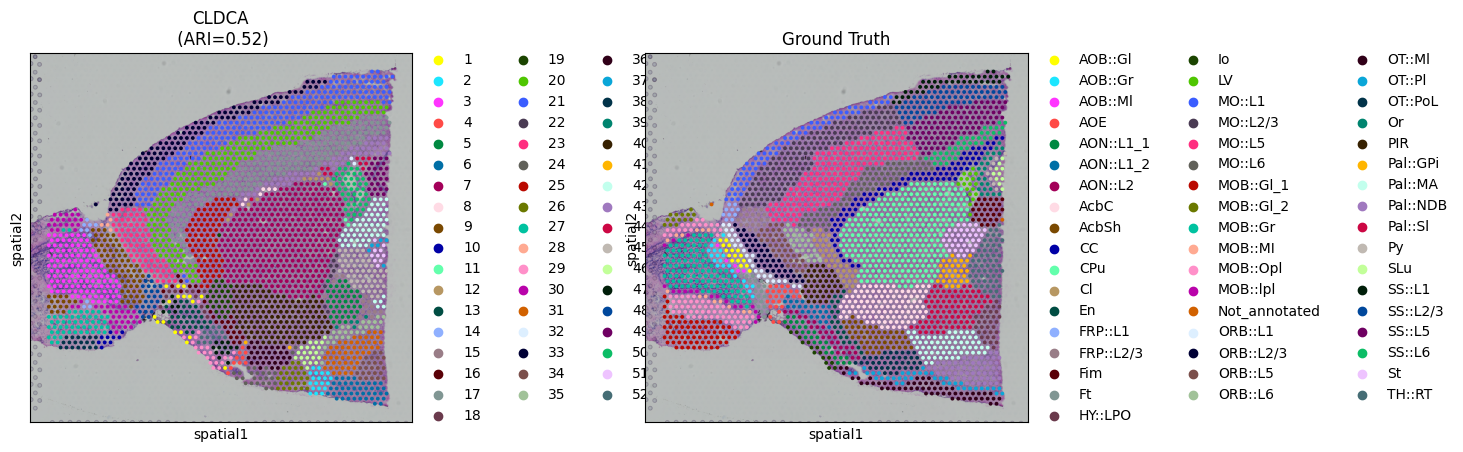

In [13]:
sc.pl.spatial(adata, color=["domain", "layer_guess"], title=[f"CLDCA\n (ARI={ARI:.2f})", "Ground Truth"])

In [12]:
def compute_NMI(adata, gt_key, pred_key):
    return normalized_mutual_info_score(adata.obs[gt_key], adata.obs[pred_key])
compute_NMI(adata, 'layer_guess', 'domain')

0.7120067110221441